In [5]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict

import xgboost as xgb
import xgbfir

from tqdm import tqdm_notebook, tnrange

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

c:\Users\vladka\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
burst_oscore_cols = [ 'burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0']

In [7]:
data_awake = pd.read_excel('data/awake.xls')
data_awake = data_awake.drop(['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length',
                             'burst_index',  'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)
for c in burst_oscore_cols:
    data_awake = data_awake[data_awake[c] > 0.]

In [8]:
data_sleep = pd.read_excel('data/sleep.xls')
data_sleep = data_sleep.drop(['doc_name', 'data_name', 'interval_name', 'spike_count', 'filter_length',
                             'burst_index', 'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)
for c in burst_oscore_cols:
    data_sleep = data_sleep[data_sleep[c] > 0.]

In [9]:
data_sleep.columns.values

array(['burst_mean', 'burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0', 'burst_percent',
       'burst_spike_percent', 'cv', 'firing_rate', 'frequency_variance',
       'interburst_interval', 'isi_mean', 'isi_median', 'isi_std',
       'kurtoisis', 'lv', 'mean_isi_in_burst', 'mean_spikes_in_burst',
       'median_isi_in_burst', 'nu', 'oscore_12.0_20.0', 'oscore_20.0_30.0',
       'oscore_3.0_8.0', 'oscore_30.0_60.0', 'oscore_60.0_90.0',
       'oscore_8.0_12.0', 'patient', 'skewness'], dtype=object)

In [10]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

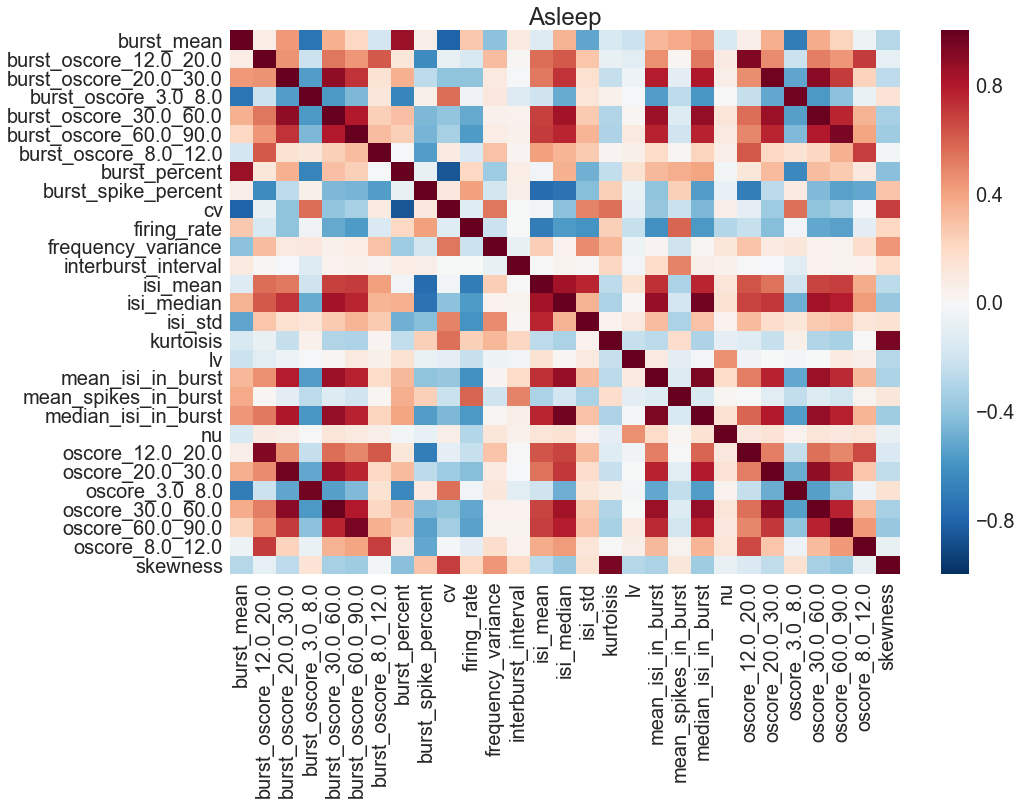

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(data_sleep.corr())
plt.title('Asleep')

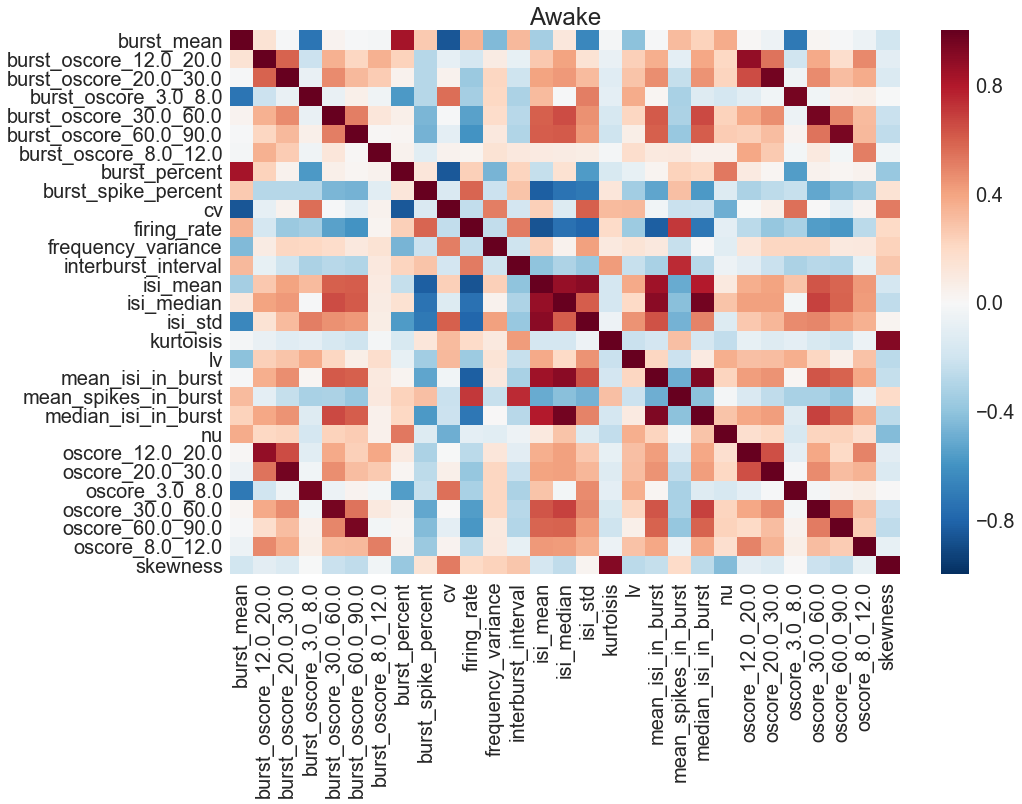

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(data_awake.corr())
plt.title('Awake')

In [13]:
data_sleep['awake'] = 0
data_awake['awake'] = 1

data = pd.concat([data_sleep, data_awake], ignore_index=True)
# data = data.join(pd.get_dummies(data['type'])).drop(['type'], axis=1)

In [14]:
patients = data['patient']
# data = data.drop(['burst_index',  'patient', 'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)

In [15]:
for c in burst_oscore_cols:
    data = data[data[c] > 0.]

In [16]:
data.to_csv('data_cleaned.csv', index=False)

In [17]:
X = data.drop(['awake'], axis=1)
y = data['awake']

In [50]:
def simple_cv(X, y, params, plot=True):
    X = X.drop(['patient'], axis=1)
    model = xgb.XGBClassifier(**params)

    acc = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    probs = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
    fpr, tpr, _ = roc_curve(y, probs)
    auc_score = auc(fpr, tpr)
    
    if plot:
        plt.figure(figsize=(15,10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('CV by folds, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))
    
#     if save_params:
#         xgbfir.saveXgbFI(model.booster(), feature_names=X.columns.values, OutputXlsxFile = 'awake_interactions_depth_3.xlsx')
    
    return acc, auc_score

In [51]:
def patient_cv(X, y, params={'learning_rate':0.125, 'max_depth':3, 'n_estimators':400}, plot=True):
    all_idx = np.array(range(X.shape[0]))
    
    names = set(X['patient'])
    patients = X['patient']
    X = X.drop(['patient'], axis=1)
    
    X = X.as_matrix()
    y = np.array(y)
        
    y_pred = np.zeros(y.shape[0], dtype=int)
    probs = np.zeros(y.shape[0], dtype=float)
    acc = list()
    
    for p in names:
        test_idx = np.where(patients == p)
        train_idx = np.delete(all_idx, test_idx, 0)
        
        X_train = X[train_idx]
        X_test = X[test_idx]
        
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)
        
        curr_pred = model.predict(X_test)
        
        y_pred[test_idx] = curr_pred
        probs[test_idx] = model.predict_proba(X_test)[:,1]
        
        acc.append(accuracy_score(y_test, curr_pred))
        
    acc = accuracy_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_score = auc(fpr, tpr)
    
    if plot:
        plt.figure(figsize=(15,10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('CV by patients, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))
    
    return acc, auc_score

In [22]:
data_cols = ['burst_mean', 'burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0', 'burst_percent',
       'burst_spike_percent', 'cv', 'firing_rate', 'frequency_variance',
       'interburst_interval', 'isi_mean', 'isi_median', 'isi_std',
       'kurtoisis', 'lv', 'mean_isi_in_burst', 'mean_spikes_in_burst',
       'median_isi_in_burst', 'nu', 'oscore_12.0_20.0', 'oscore_20.0_30.0',
       'oscore_3.0_8.0', 'oscore_30.0_60.0', 'oscore_60.0_90.0',
       'oscore_8.0_12.0', 'skewness']

11


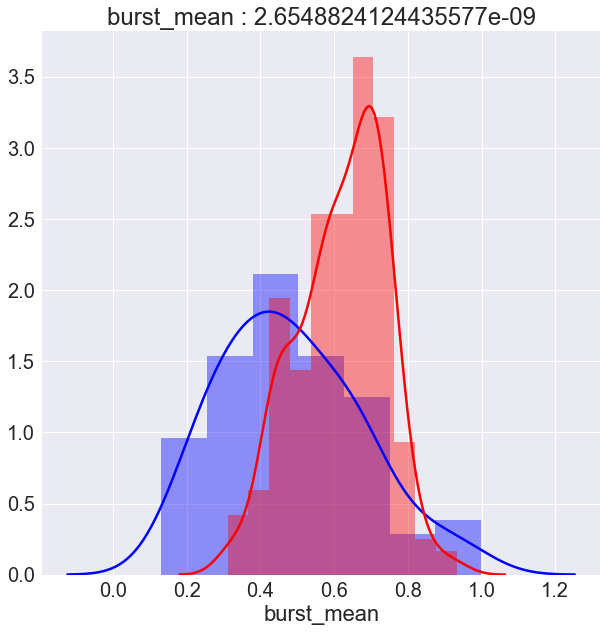

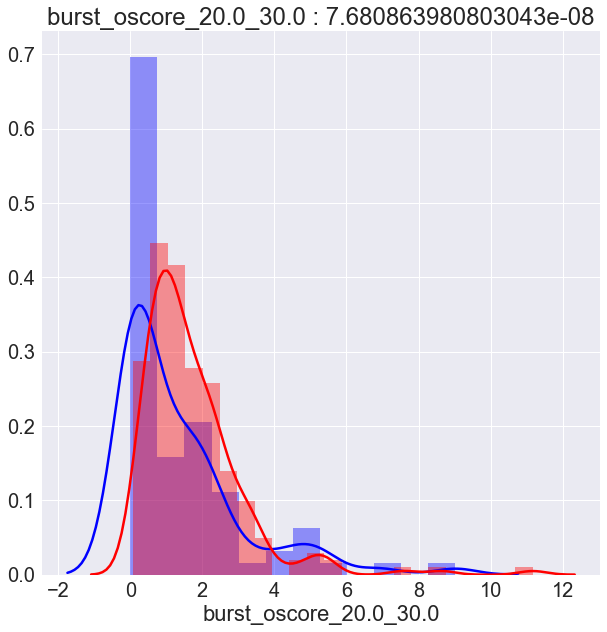

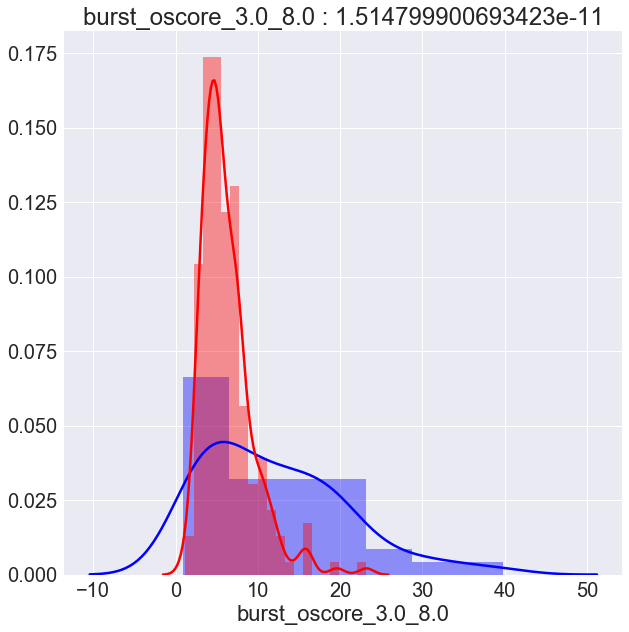

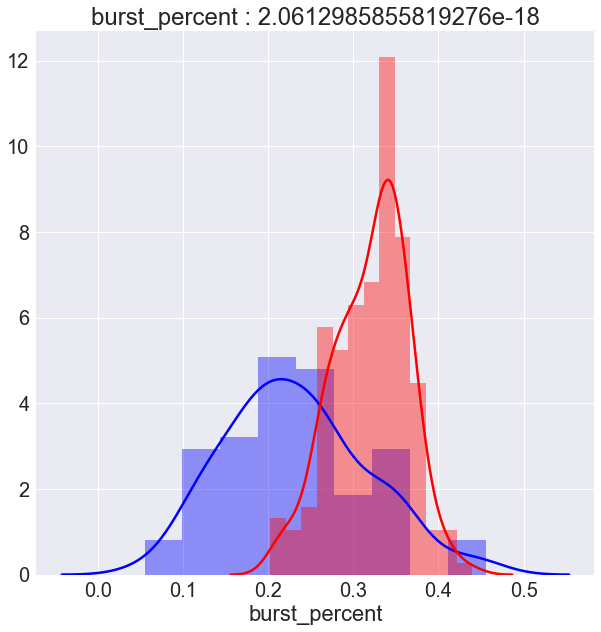

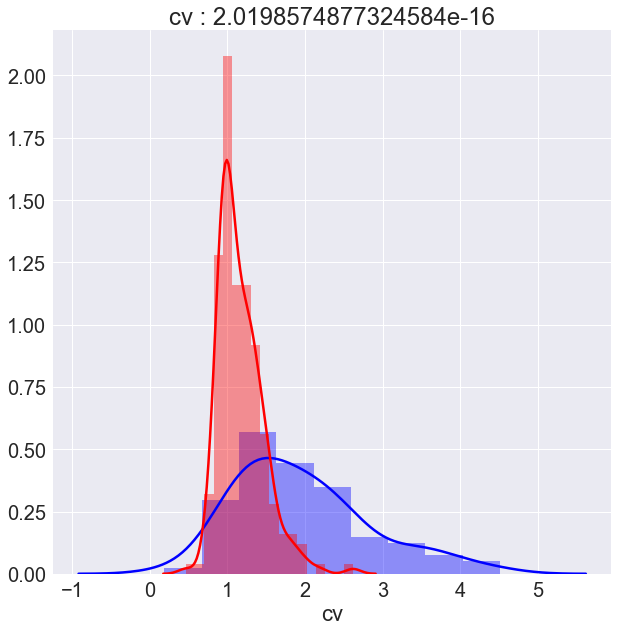

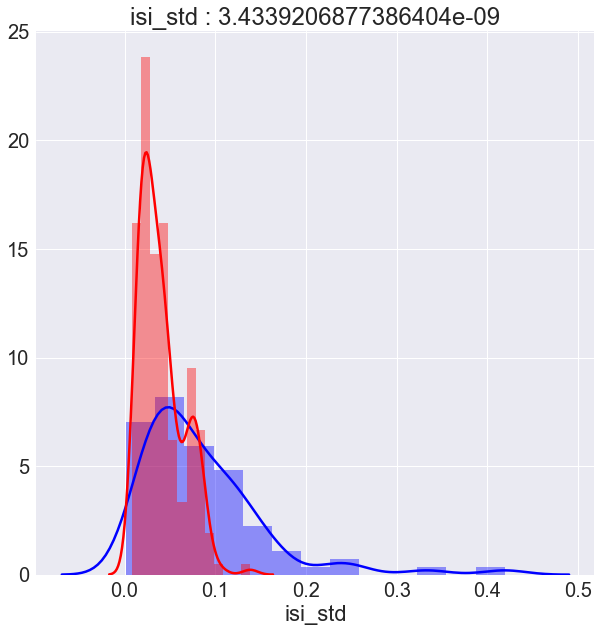

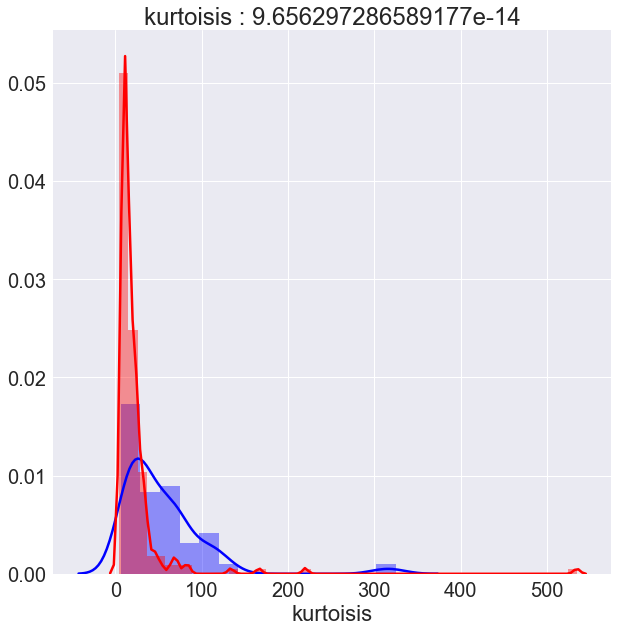

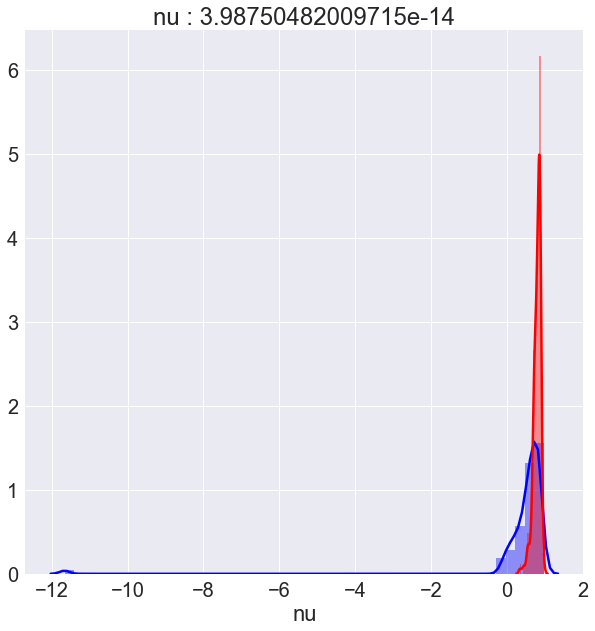

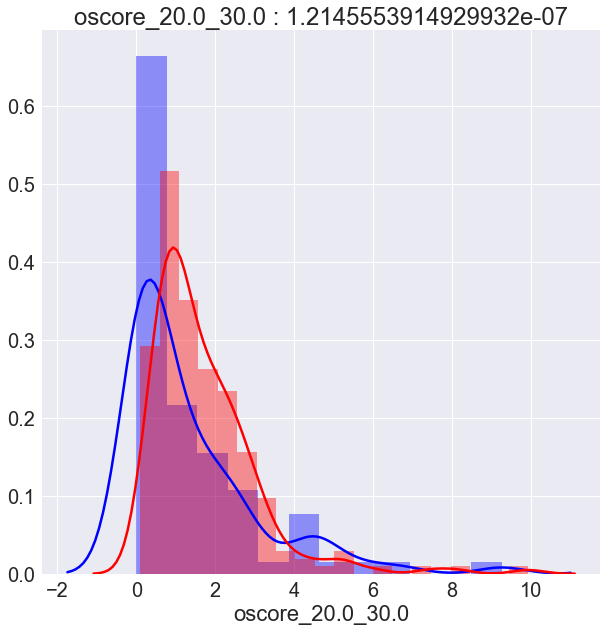

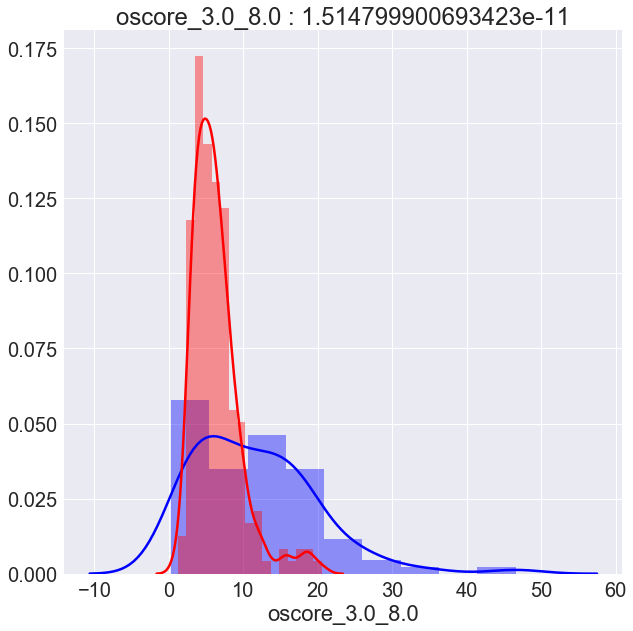

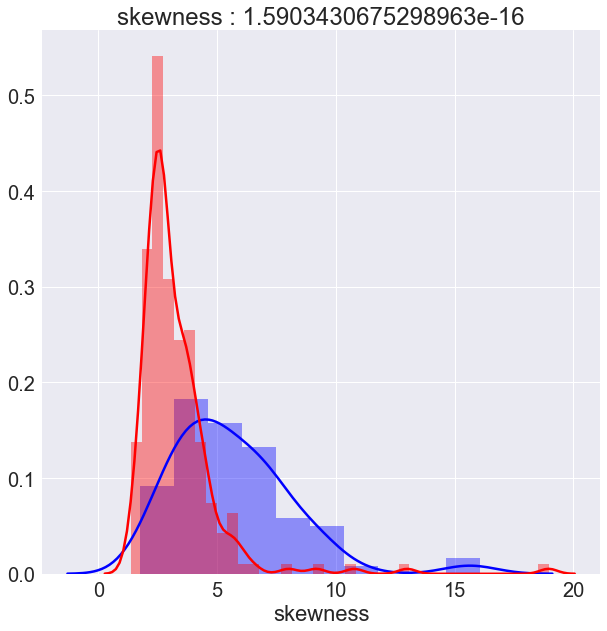

In [23]:
count = 0
for c in data_cols:
    sleep_data = data_sleep[c]
    awake_data = data_awake[c]
    
#     stat, pval = sp.stats.ttest_ind_from_stats(np.mean(sleep_data), np.var(sleep_data), len(sleep_data),
#                                                np.mean(awake_data), np.var(awake_data), len(awake_data))
    stat, pval = sp.stats.ks_2samp(sleep_data, awake_data)
#     print(c, stat, pval)
    if pval < 1e-5:
        plt.figure(figsize=(10,10))
        sns.distplot(sleep_data, color='blue', label='sleep')
        sns.distplot(awake_data, color='red', label='awake')
        plt.title('{} : {}'.format(c, pval))
        count += 1
print(count)

In [35]:
def fix_params(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    return params

def score(X, y, pbar, cv_type, metric, params):
    params = fix_params(params)
    
    if cv_type == 'patient':
        accuracy, auc = patient_cv(X, y, params, plot=False)
    elif cv_type == 'simple':
        accuracy, auc = simple_cv(X, y, params, plot=False)
    else:
        raise RuntimeError('Uknown cv type!')
    
    if metric == 'auc':
        loss = -auc
    elif metric == 'accuracy':
        loss = -accuracy
    else:
        raise RuntimeError('Uknown metric for scoring!')
        
    pbar.update(1)
    
    return {'loss': loss, 'status': STATUS_OK}

def optimize(X, y, trials, cv_type='simple', metric='accuracy', max_evals=250):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
             }
    
    pbar = tqdm_notebook(total=max_evals)
    best_params = fmin(lambda params: score(X, y, pbar, cv_type, metric, params), 
                       space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

    return fix_params(best_params)

Widget Javascript not detected.  It may not be installed or enabled properly.


(0.84300341296928327, 0.82233994076099337)

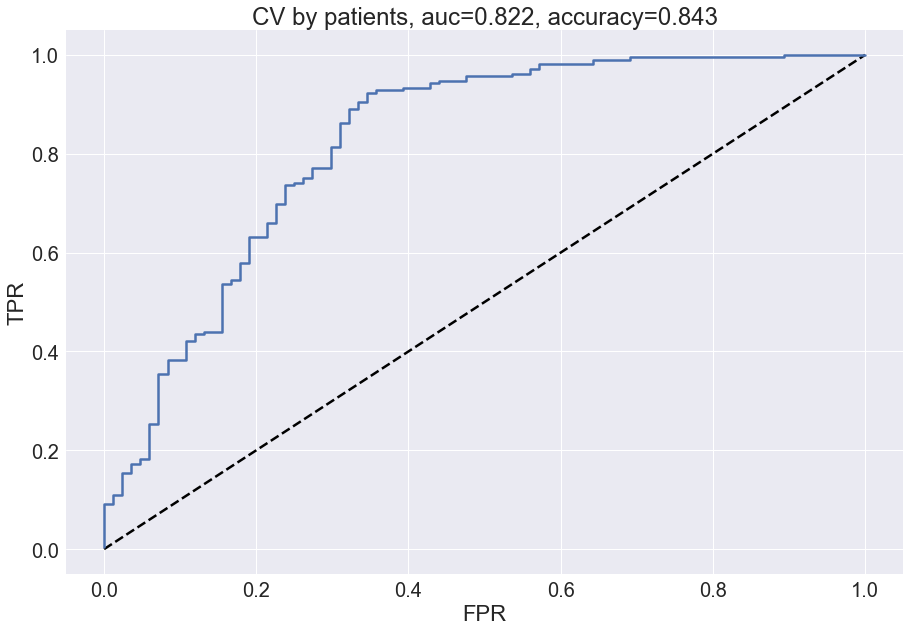

In [53]:
trials = Trials()
best_params = optimize(X, y, trials, 'patient')

patient_cv(X, y, best_params)

Widget Javascript not detected.  It may not be installed or enabled properly.


(0.88064228367528996, 0.88334472544998854)

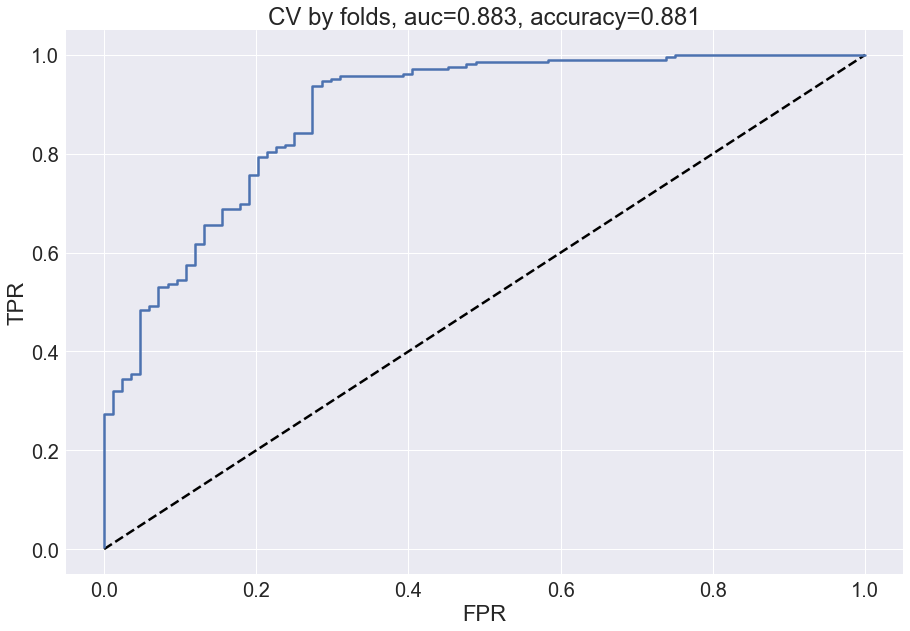

In [54]:
trials = Trials()
best_params = optimize(X, y, trials, 'simple')

simple_cv(X, y, best_params)